In [25]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# print("TensorFlow version:", tf.__version__)

DATASET_PATH = "genres_original" 
GENRES = sorted(os.listdir(DATASET_PATH))
# print("Detected genres:", GENRES)


In [26]:
def maybe_add_noise(y, noise_level=0.005, p=0.5):
    if np.random.rand() < p:
        noise = noise_level * np.random.randn(len(y))
        return y + noise
    return y

In [27]:
SR = 22050
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
IMG_SIZE = (128, 128) 

def audio_to_melspec(file_path, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    y, sr = librosa.load(file_path, sr=sr)
    y, _ = librosa.effects.trim(y)
    y = y[:sr*10]
    y = maybe_add_noise(y)
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )

    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_db  # shape: (n_mels, time_frames)


def pad_or_crop(mel_db, target_shape=IMG_SIZE):

    target_freq, target_time = target_shape
    freq, time = mel_db.shape

    if freq < target_freq:
        pad_width = target_freq - freq
        mel_db = np.pad(mel_db, ((0, pad_width), (0, 0)), mode="constant", constant_values=mel_db.min())
    elif freq > target_freq:
        start = (freq - target_freq) // 2
        mel_db = mel_db[start:start + target_freq, :]


    freq, time = mel_db.shape  
    if time < target_time:
        pad_width = target_time - time
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode="constant", constant_values=mel_db.min())
    elif time > target_time:
        start = (time - target_time) // 2
        mel_db = mel_db[:, start:start + target_time]

    return mel_db 


In [28]:
X = []
y = []

for genre in GENRES:
    genre_path = os.path.join(DATASET_PATH, genre)
    if not os.path.isdir(genre_path):
        continue

    files = [f for f in os.listdir(genre_path) if f.endswith(".wav")]
    print(f"Processing genre: {genre}, files: {len(files)}")

    for file_name in files:
        file_path = os.path.join(genre_path, file_name)
        try:
            mel_db = audio_to_melspec(file_path)
            mel_resized = pad_or_crop(mel_db, target_shape=IMG_SIZE)

            mel_norm = (mel_resized - mel_resized.min()) / (mel_resized.max() - mel_resized.min() + 1e-9)

            mel_norm = np.expand_dims(mel_norm, axis=-1)

            X.append(mel_norm)
            y.append(genre)
        except Exception as e:
            print("Error processing", file_path, ":", e)

X = np.array(X, dtype=np.float32)
y = np.array(y)

print("X shape:", X.shape) 
print("y shape:", y.shape)


Processing genre: blues, files: 100
Processing genre: classical, files: 100
Processing genre: country, files: 100
Processing genre: disco, files: 100
Processing genre: hiphop, files: 100
Processing genre: jazz, files: 100


C:\Users\ZhuanZ\AppData\Local\Temp\ipykernel_17364\2900534264.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
c:\Users\ZhuanZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing genres_original\jazz\jazz.00054.wav : 
Processing genre: metal, files: 100
Processing genre: pop, files: 100
Processing genre: reggae, files: 100
Processing genre: rock, files: 100
X shape: (999, 128, 128, 1)
y shape: (999,)


In [29]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)
print("Encoded:", set(y_encoded))

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.3,      
    random_state=42,
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,     
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Encoded: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Train: (699, 128, 128, 1) Val: (150, 128, 128, 1) Test: (150, 128, 128, 1)


In [30]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(2, 2),

        layers.GlobalAveragePooling2D(),

        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

input_shape = X_train.shape[1:] 
cnn_model = build_cnn(input_shape, num_classes)
cnn_model.summary()


c:\Users\ZhuanZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,026 (1.61 MB)

 Trainable params: 422,026 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.0982 - loss: 2.3068 - val_accuracy: 0.1000 - val_loss: 2.3024 - learning_rate: 0.0010
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.0928 - loss: 2.3036 - val_accuracy: 0.1400 - val_loss: 2.3014 - learning_rate: 0.0010
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.0967 - loss: 2.3023 - val_accuracy: 0.1000 - val_loss: 2.3007 - learning_rate: 0.0010
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.1048 - loss: 2.3024 - val_accuracy: 0.1533 - val_loss: 2.2795 - learning_rate: 0.0010
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.1359 - loss: 2.2675 - val_accuracy: 0.1267 - val_loss: 2.2482 - learning_rate: 0.0010
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.1715 - loss: 2.2075 - val_accuracy: 0.2200 - val_loss: 2.1416 - learning_rate: 0.0010
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.1877 - loss: 2.

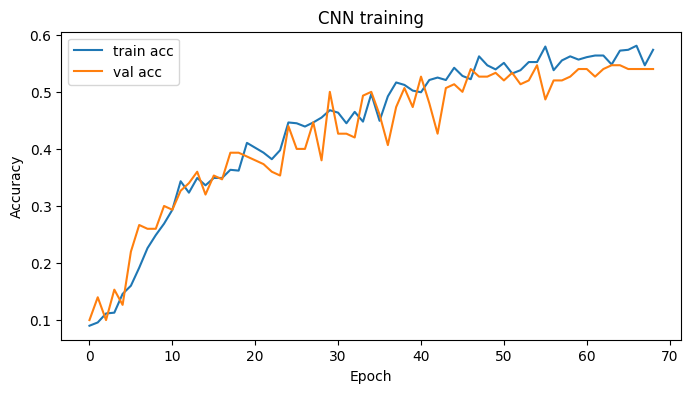

In [31]:
EPOCHS = 200
BATCH_SIZE = 32

early_stop = EarlyStopping(
    monitor="val_loss",        
    patience=10,                
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,               
    patience=3,                
    min_lr=1e-6
)

history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stop,reduce_lr]
    
)

plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN training")
plt.show()


Test accuracy: 0.5133
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Classification report:
              precision    recall  f1-score   support

       blues       0.40      0.53      0.46        15
   classical       0.61      0.73      0.67        15
     country       0.36      0.27      0.31        15
       disco       0.33      0.13      0.19        15
      hiphop       0.53      0.60      0.56        15
        jazz       0.64      0.47      0.54        15
       metal       0.68      0.87      0.76        15
         pop       0.60      0.80      0.69        15
      reggae       0.89      0.53      0.67        15
        rock       0.16      0.20      0.18        15

    accuracy                           0.51       150
   macro avg       0.52      0.51      0.50       150
weighted avg       0.52      0.51      0.50       150



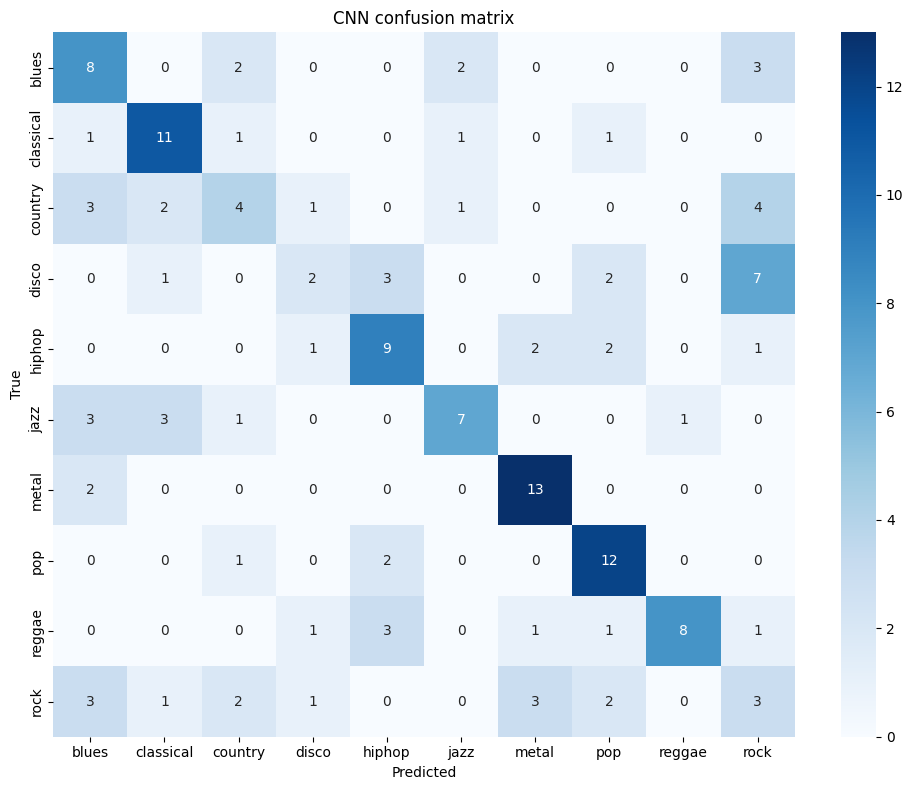

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN confusion matrix")
plt.tight_layout()
plt.show()
